# Trip times analysis - Summary

### Background
A dataset of ~14.3 million records was provided containing details of Lyft trips. These records contained coordinats of start and end location along with the start time of the trip. Trip duration (in seconds) was provided for ~12.9 million records (the training set). The remaining 1.3 million records did not contain trip duration and it is desired to predict duration for these records (the test set).

### Methods
Data was first explored to determine its characteristics. 

### Results
?

### Conclusion
?


In [163]:
# display output from all cmds just like Python shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import platform
print('python.version = ', platform.python_version())
import IPython
print('ipython.version =', IPython.version_info)

import numpy as np
print('numpy.version = ', np.__version__)
import pandas as pd
print('pandas.version = ', pd.__version__)

import sklearn
print('sklearn.version = ', sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
print('matplotlib.version = ', matplotlib.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('seaborn.version = ', sns.__version__)

from scipy import stats
from scipy.stats import norm

import calendar
from haversine import haversine

python.version =  3.4.3
ipython.version = (6, 2, 1, '')
numpy.version =  1.13.3
pandas.version =  0.20.3
sklearn.version =  0.19.1
matplotlib.version =  2.1.0
seaborn.version =  0.8.1


## Import data

In [141]:
# import training set
train_all = pd.read_csv("../data/train.csv", index_col=0, header=0)
train_all.shape
train_all.info()

# import test data
test = pd.read_csv("../data/test.csv", index_col=0, header=0)
test.shape
test.info()


/usr/lib64/python3.4/dist-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(12905715, 6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12905715 entries, 0 to 12905714
Data columns (total 6 columns):
start_lng          float64
start_lat          float64
end_lng            float64
end_lat            float64
start_timestamp    int64
duration           int64
dtypes: float64(4), int64(2)
memory usage: 689.2 MB


(1434344, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434344 entries, 0 to 1434343
Data columns (total 5 columns):
start_lng          1434344 non-null float64
start_lat          1434344 non-null float64
end_lng            1434344 non-null float64
end_lat            1434344 non-null float64
start_timestamp    1434344 non-null int64
dtypes: float64(4), int64(1)
memory usage: 65.7 MB


In [142]:
# create subset of training set for experimentation
train = train_all.sample(1000000)
train.head()
train.shape


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
row_id,,,,,,
11224048,-73.991783,40.726505,-74.003014,40.731865,1447181310,604
7933879,-73.953766,40.775169,-73.945694,40.779633,1438714344,321
5236149,-73.990669,40.728336,-73.978073,40.735828,1431231273,465
3618720,-74.015572,40.710663,-73.987335,40.762821,1429301248,1519
2820572,-73.970879,40.751575,-74.010216,40.709751,1426775629,822


(1000000, 6)

### Missing values


In [143]:
train_all.isnull().sum()
train.isnull().sum()
test.isnull().sum()

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
dtype: int64

## Explore response (duration)

From the plots below, the response (trip duration in seconds) is skewed right with a natural lower bound at 0. Skewness and kurtosis indicate a high degree of asymmetry and heavy tails to the right 

In such cases, log transformation usually normalizes the distribution (Box-Cox transformation is alternative). This is seen from the QQ plot as well as values for skewness & kurtosis for the log-transformed distribution.

In [144]:
train["duration"].describe() # Summary statistics

count    1000000.000000
mean         842.380186
std          717.341046
min            1.000000
25%          400.000000
50%          665.000000
75%         1076.000000
max        43178.000000
Name: duration, dtype: float64

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([    1,     1,     1, ..., 42964, 42992, 43178])),
 (604.29983351349006, 842.38018599999975, 0.84241240315907451))

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([  0.        ,   0.        ,   0.        , ...,  10.66811783,
          10.66876933,  10.67308639])),
 (0.76645490827308593, 6.4632917980488793, 0.98733094957286582))

8.5909999999999993

319.30000000000001

-0.67500000000000004

2.8490000000000002

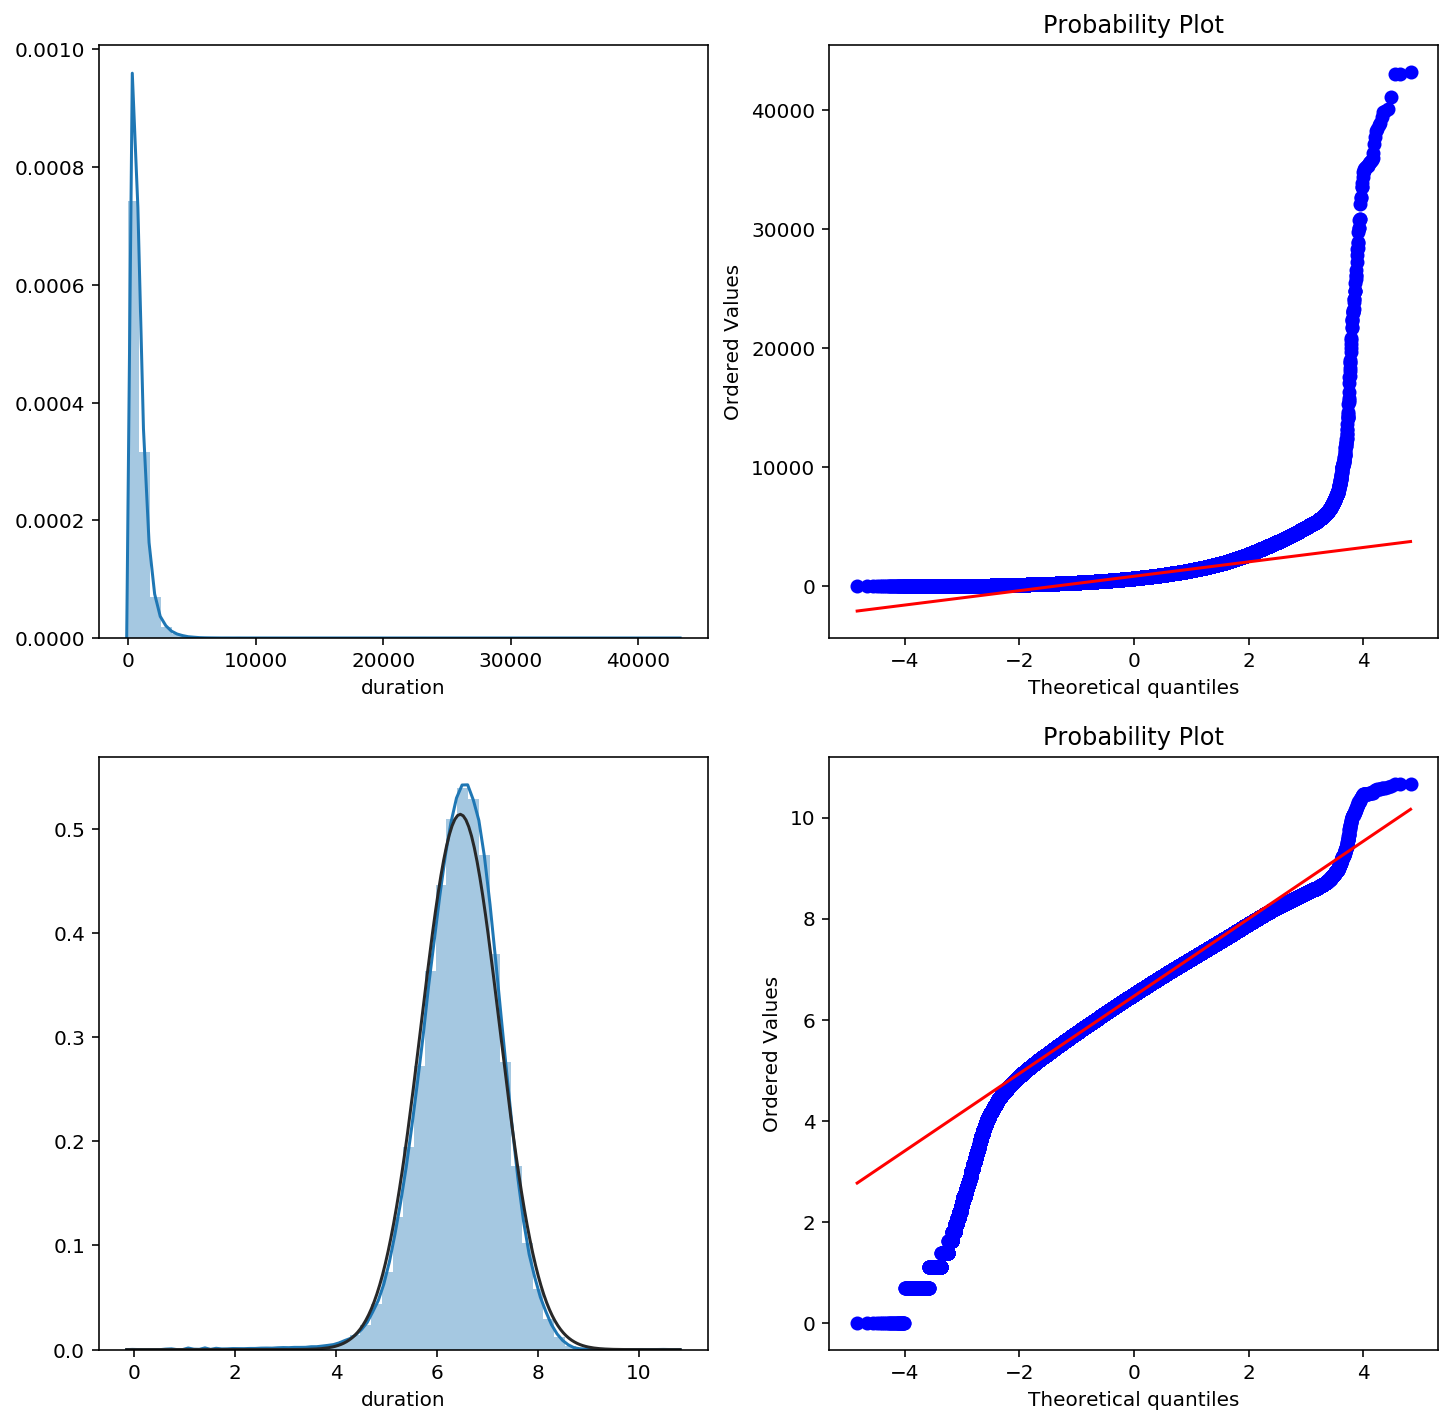

In [145]:
# Check Normality with histogram & QQ plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
sns.distplot(train["duration"], hist=True, kde=True, ax=axes[0,0])
stats.probplot(train["duration"], dist="norm", plot=axes[0,1])

log_duration = np.log(train["duration"])
sns.distplot(log_duration, hist=True, kde=True, fit=norm, ax=axes[1,0], label="log(duration)")
stats.probplot(log_duration, dist="norm", plot=axes[1,1])

# Check Normality with skewness & kurtosis
# Skewness = measure of symmetry (for Normal distribution = 0)
# Kurtosis = measure of heavy/light-tailed-ness (for Normal distribution = 0)
np.round(train["duration"].skew(),3) # durations are skewed right since min duration = 0
np.round(train["duration"].kurt(),3) # very heavy tailed distribution

np.round(log_duration.skew(),3) # almost symmetric
np.round(log_duration.kurt(),3) # very close to ideal value of 0; tails are slightly heavy


In [146]:
# Replace duration with log(duration)
train["duration"] = log_duration
train.head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
row_id,,,,,,
11224048,-73.991783,40.726505,-74.003014,40.731865,1447181310,6.403574
7933879,-73.953766,40.775169,-73.945694,40.779633,1438714344,5.771441
5236149,-73.990669,40.728336,-73.978073,40.735828,1431231273,6.142037
3618720,-74.015572,40.710663,-73.987335,40.762821,1429301248,7.325808
2820572,-73.970879,40.751575,-74.010216,40.709751,1426775629,6.711740


## Explore time covariate

Start timestamps are given in Unix epoch seconds. These values can be converted to components of UTC dates & times. From the plots below, there doesn't appear to be a strong correlation between duration and any of the components of trip start time other than "hour". Trips starting around 10am take slightly less time than those starting early in the morning or late in the night.

In [147]:
# split timestamp into components
utcdt = pd.to_datetime(train['start_timestamp'], unit='s')

train["year"] = utcdt.dt.year
train["month"] = utcdt.dt.month
train["dayofweek"] = utcdt.dt.dayofweek
train["dayofmonth"] = utcdt.dt.day
train["dayofyear"] = utcdt.dt.dayofyear
train["hour"] = utcdt.dt.hour
train["minute"] = utcdt.dt.minute

train.head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute
row_id,,,,,,,,,,,,,
11224048,-73.991783,40.726505,-74.003014,40.731865,1447181310,6.403574,2015,11,1,10,314,18,48
7933879,-73.953766,40.775169,-73.945694,40.779633,1438714344,5.771441,2015,8,1,4,216,18,52
5236149,-73.990669,40.728336,-73.978073,40.735828,1431231273,6.142037,2015,5,6,10,130,4,14
3618720,-74.015572,40.710663,-73.987335,40.762821,1429301248,7.325808,2015,4,4,17,107,20,7
2820572,-73.970879,40.751575,-74.010216,40.709751,1426775629,6.711740,2015,3,3,19,78,14,33


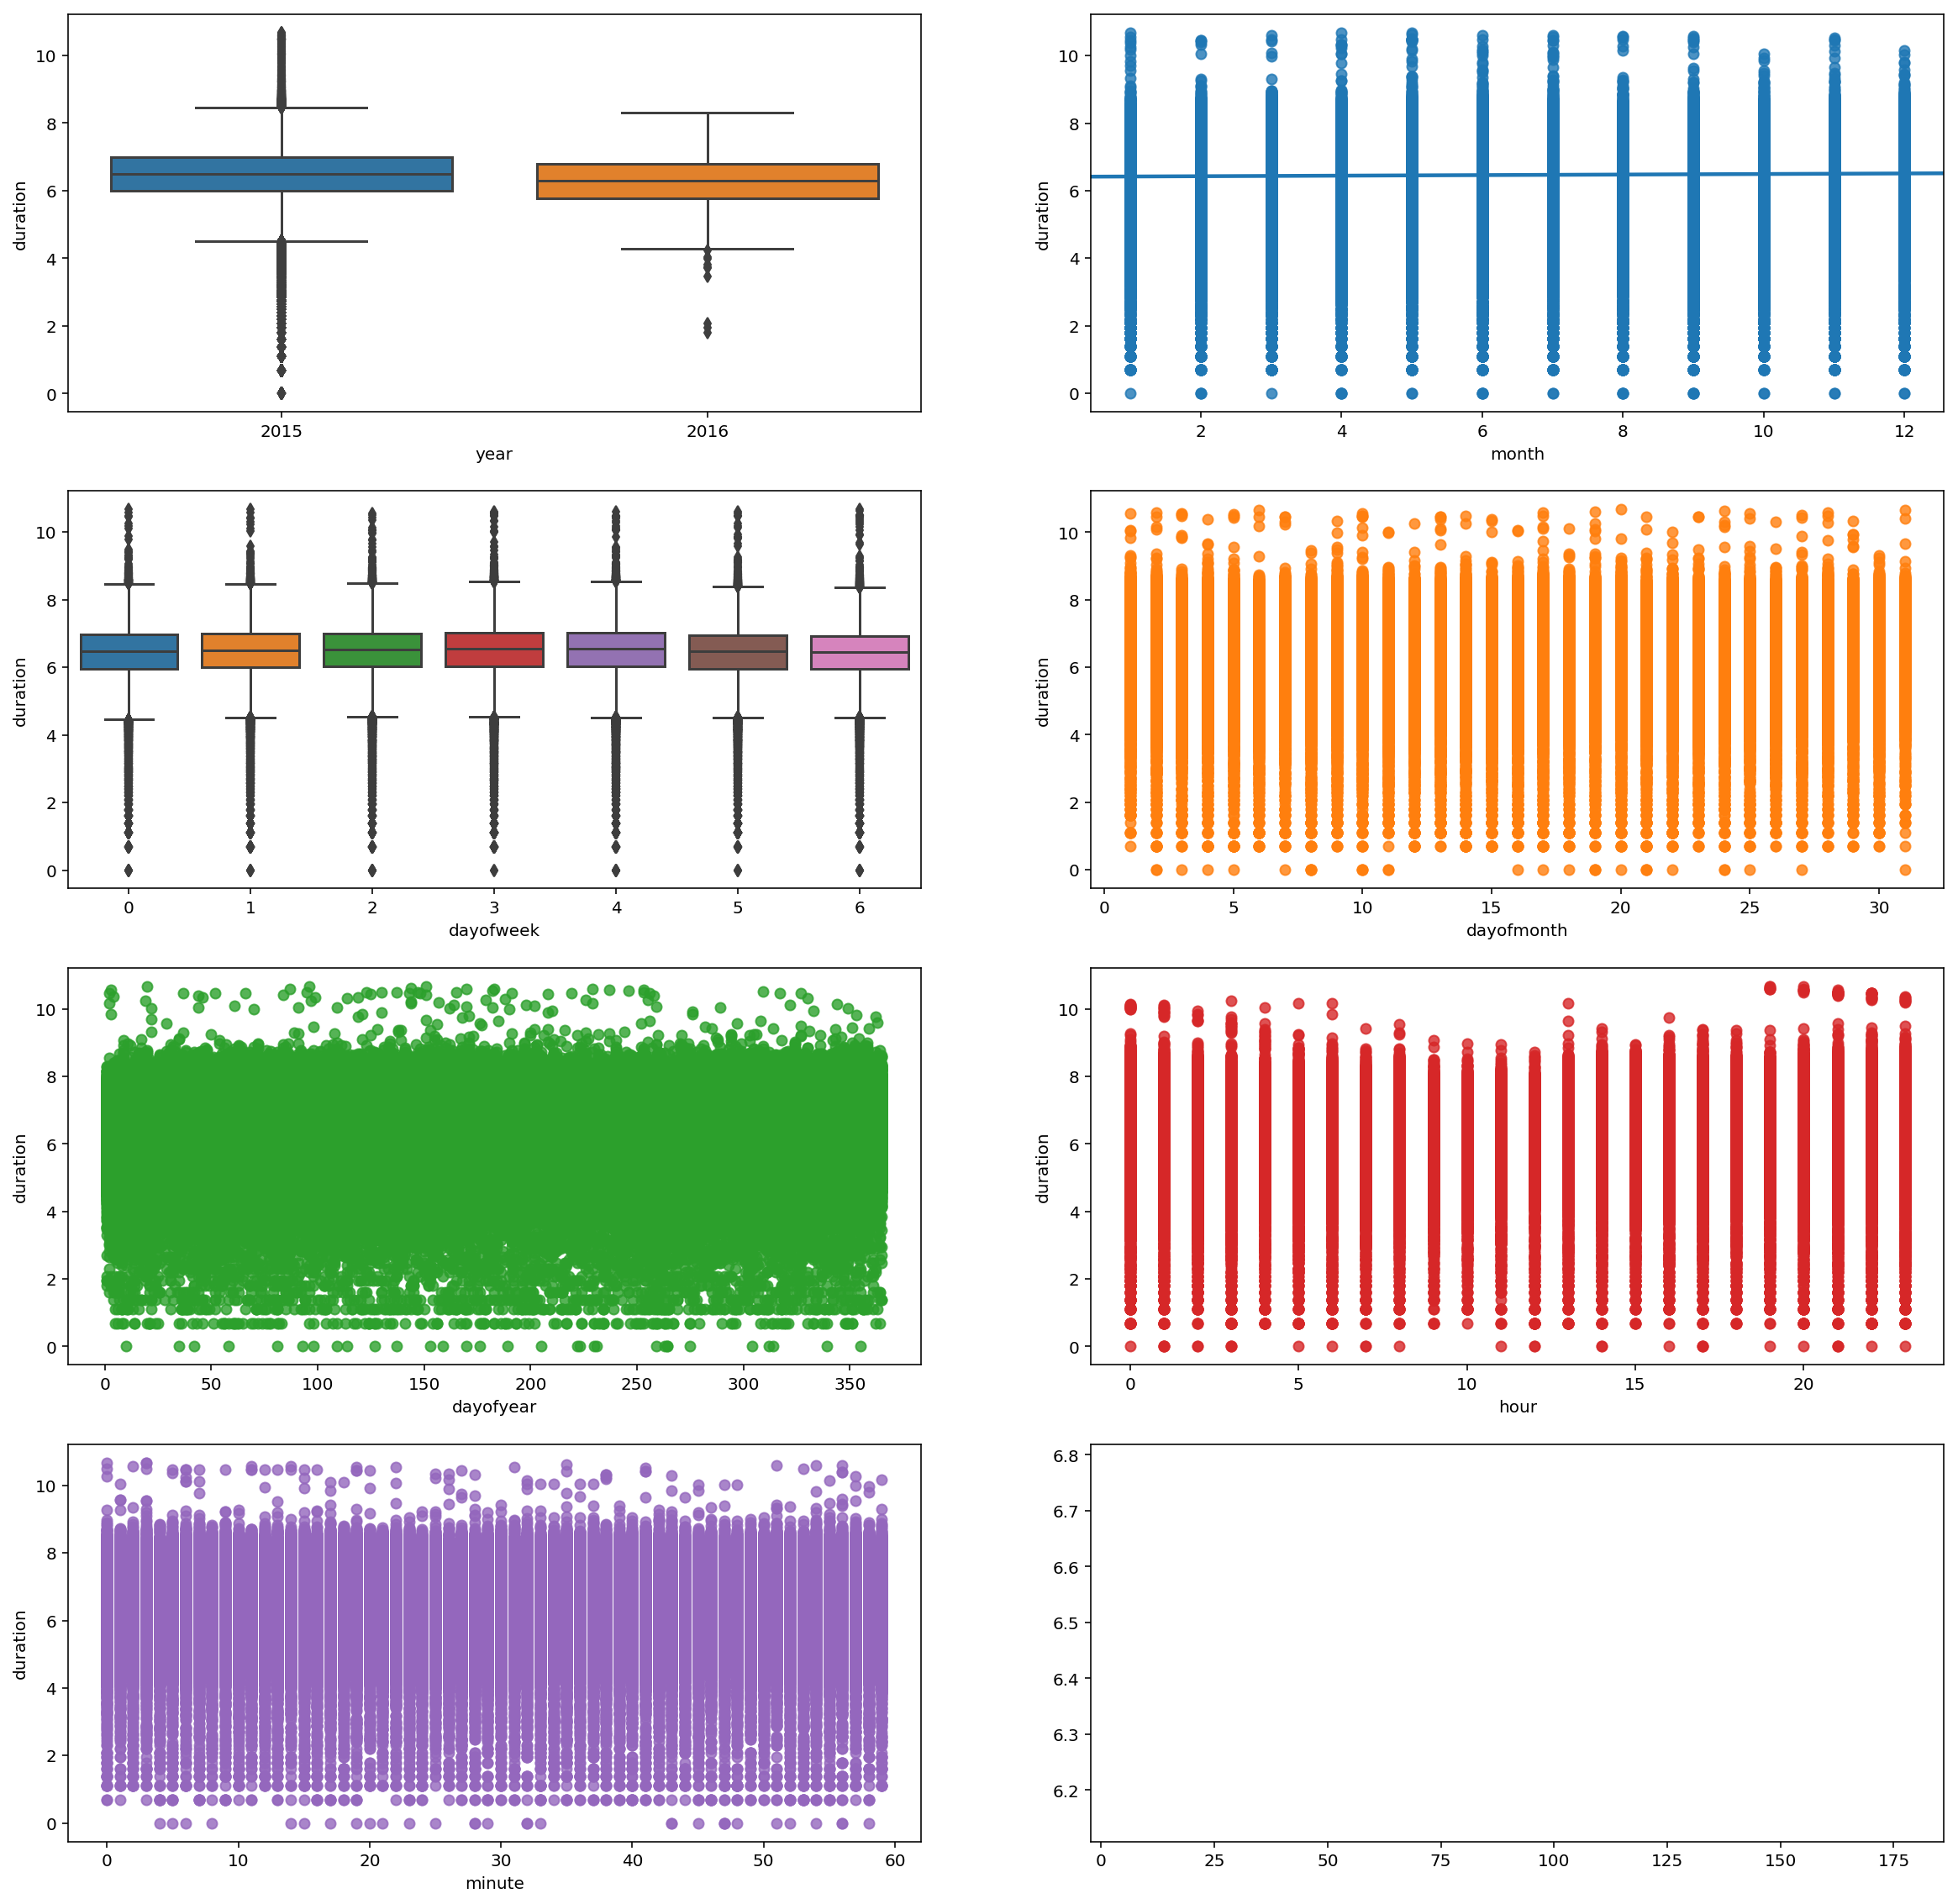

In [162]:
# Explore relationship between duration & start time components
fig, axes = plt.subplots(4, 2, figsize=(20,20))

sns.boxplot(x=train["year"], y=log_duration, ax=axes[0,0])
sns.regplot(x=train["month"], y=log_duration, ax=axes[0,1])

sns.boxplot(x=train["dayofweek"], y=log_duration, ax=axes[1,0])
sns.regplot(x=train["dayofmonth"], y=log_duration, fit_reg=False, ax=axes[1,1])

sns.regplot(x=train["dayofyear"], y=log_duration, fit_reg=False, ax=axes[2,0])
sns.regplot(x=train["hour"], y=log_duration, fit_reg=False, ax=axes[2,1])

sns.regplot(x=train["minute"], y=log_duration, fit_reg=False, ax=axes[3,0])


## Explore location covariates

The given longitude & latitude coordinates have a precision of 6 decimal places. This is sub-meter resolution an sis too specific. In order to generalize from this dataset, it is better to reduce precision and consider neighborhoods within 100m of original location instead of the original location itself. This is done by rounding up coordinates to 3 decimal places.

In [149]:
# Create unique locations
start = train["start_lng"].map(str) + ',' + train["start_lat"].map(str)
end = train["end_lng"].map(str) + ',' + train["end_lat"].map(str)

# Do locations occur more than once?
start.value_counts().head(10)
end.value_counts().head(10)


-74.186302,40.693142             22
-73.9394,40.754692               18
-73.948639,40.7449               12
-73.874496,40.77409              12
-73.870888,40.773788             11
-73.874557,40.774109             11
-73.874489,40.774071             10
-73.874527,40.77409               9
-73.874481,40.774052000000005     9
-73.87085,40.77375                9
dtype: int64

-74.186302,40.693142             22
-73.9394,40.754692               18
-73.948639,40.7449               12
-73.936501,40.758293              8
-73.988457,40.731503000000004     8
-73.992683,40.720501              7
-73.994652,40.750439              6
-74.002808,40.76054               6
-73.994629,40.750481              6
-74.002724,40.76059               6
dtype: int64

In [150]:
# reduce precision of start and end location and consider only 100m neighborhood around original location
train["start_lng"] = np.round(train["start_lng"], 3)
train["start_lat"] = np.round(train["start_lat"], 3)
train["end_lng"] = np.round(train["end_lng"], 3)
train["end_lat"] = np.round(train["end_lat"], 3)

train.head() # verify rounding occured as expected

# Re-create unique locations
start = train["start_lng"].map(str) + ',' + train["start_lat"].map(str)
end = train["end_lng"].map(str) + ',' + train["end_lat"].map(str)

# Now see how often these "neighborhoods" occur
train["start_lng"].value_counts().head(10)
train["start_lat"].value_counts().head(10)
train["end_lng"].value_counts().head(10)
train["end_lat"].value_counts().head(10)

start.value_counts().head()
end.value_counts().head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute
row_id,,,,,,,,,,,,,
11224048,-73.992,40.727,-74.003,40.732,1447181310,6.403574,2015,11,1,10,314,18,48
7933879,-73.954,40.775,-73.946,40.780,1438714344,5.771441,2015,8,1,4,216,18,52
5236149,-73.991,40.728,-73.978,40.736,1431231273,6.142037,2015,5,6,10,130,4,14
3618720,-74.016,40.711,-73.987,40.763,1429301248,7.325808,2015,4,4,17,107,20,7
2820572,-73.971,40.752,-74.010,40.710,1426775629,6.711740,2015,3,3,19,78,14,33


-73.982    34235
-73.991    26769
-73.990    25119
-73.988    24982
-73.981    24788
-73.989    24522
-73.992    24176
-73.978    23577
-73.987    23437
-73.983    22927
Name: start_lng, dtype: int64

40.750    24181
40.774    24000
40.751    22260
40.756    22163
40.764    21386
40.762    20497
40.757    19641
40.763    19072
40.761    18712
40.752    18309
Name: start_lat, dtype: int64

-73.982    27413
-73.991    25274
-73.979    23497
-73.981    23328
-73.978    23028
-73.983    22677
-73.992    22443
-73.985    21909
-73.990    21661
-73.980    21242
Name: end_lng, dtype: int64

40.750    22422
40.756    21565
40.764    19166
40.751    19144
40.761    19025
40.762    18423
40.759    17926
40.765    17757
40.757    17628
40.758    17613
Name: end_lat, dtype: int64

-73.994,40.751    5490
-73.782,40.645    4915
-73.991,40.75     4864
-73.871,40.774    4508
-73.873,40.774    4204
dtype: int64

-73.991,40.75     4690
-73.992,40.749    3588
-73.995,40.75     3358
-73.991,40.751    2938
-73.871,40.774    2223
dtype: int64

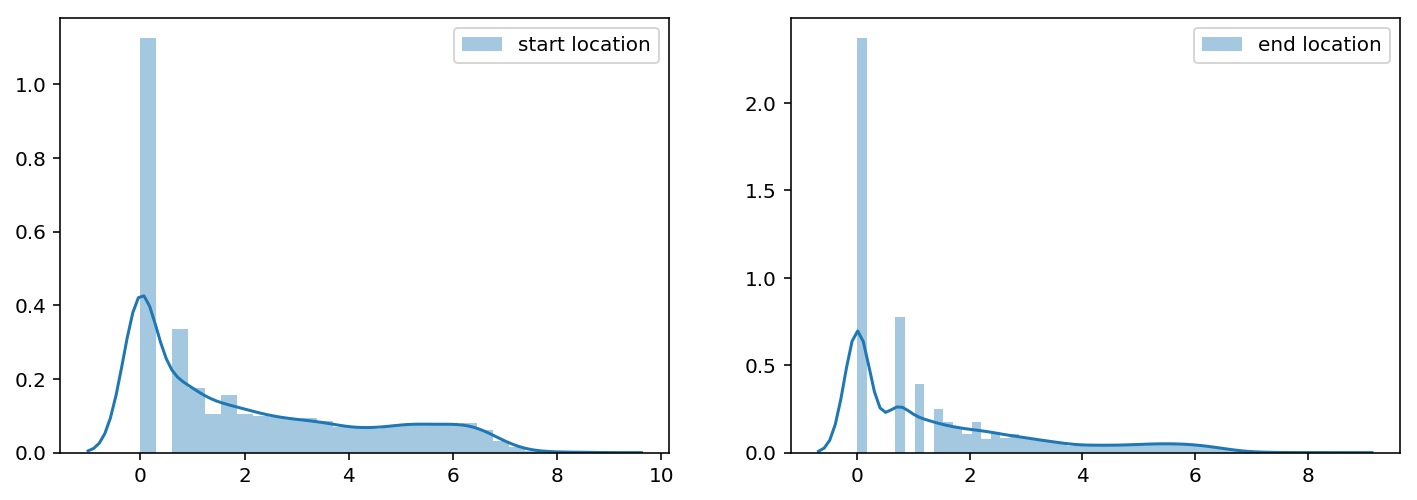

In [151]:
# Histogram of log(location frequency)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.distplot(np.log(start.value_counts()), ax=axes[0], label="start location")
sns.distplot(np.log(end.value_counts()), ax=axes[1], label="end location")

axes[0].legend()
axes[1].legend()


In [152]:
# calculate Haversine distance between start & end neighborhoods
# NOTE: this is likely to be an underestimate of the actual trip distance
def calc_dist(x):
    dist = haversine((x["start_lat"], x["start_lng"]), (x["end_lat"], x["end_lng"]), miles=True)
    dist = np.round(dist, 2)
    return dist

# Distance between points
train["distance"] = train.apply(calc_dist, axis=1)
train.head()


,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,year,month,dayofweek,dayofmonth,dayofyear,hour,minute,distance
row_id,,,,,,,,,,,,,,
11224048,-73.992,40.727,-74.003,40.732,1447181310,6.403574,2015,11,1,10,314,18,48,0.67
7933879,-73.954,40.775,-73.946,40.780,1438714344,5.771441,2015,8,1,4,216,18,52,0.54
5236149,-73.991,40.728,-73.978,40.736,1431231273,6.142037,2015,5,6,10,130,4,14,0.88
3618720,-74.016,40.711,-73.987,40.763,1429301248,7.325808,2015,4,4,17,107,20,7,3.90
2820572,-73.971,40.752,-74.010,40.710,1426775629,6.711740,2015,3,3,19,78,14,33,3.55


The plot below suggests that there is a strong relationship between duration & distance with duration increasing with distance

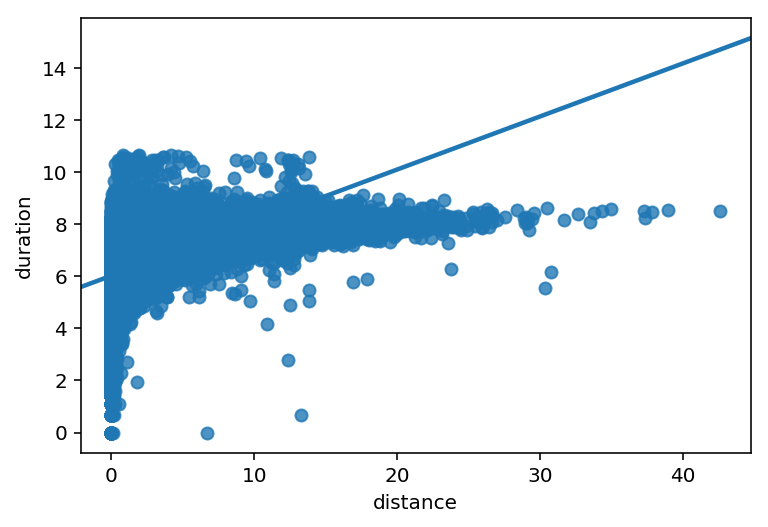

In [153]:
sns.regplot(x=train["distance"], y=train["duration"], fit_reg=True)


## Create training and validation datasets

In [155]:
# Split training set into train & validation sets for model development

y = train["duration"]
X = train.drop(["start_timestamp", "duration"], axis=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, shuffle=True)


/usr/lib64/python3.4/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,start_lng,start_lat,end_lng,end_lat,year,month,dayofweek,dayofmonth,dayofyear,hour,minute,distance
row_id,,,,,,,,,,,,
11224048,-73.992,40.727,-74.003,40.732,2015,11,1,10,314,18,48,0.67
7933879,-73.954,40.775,-73.946,40.780,2015,8,1,4,216,18,52,0.54
5236149,-73.991,40.728,-73.978,40.736,2015,5,6,10,130,4,14,0.88
3618720,-74.016,40.711,-73.987,40.763,2015,4,4,17,107,20,7,3.90
2820572,-73.971,40.752,-74.010,40.710,2015,3,3,19,78,14,33,3.55


In [158]:
# Verify dataframes
X.head()
X_train.head()
X_validation.head()
y_train.head()
y_validation.head()


,start_lng,start_lat,end_lng,end_lat,year,month,dayofweek,dayofmonth,dayofyear,hour,minute,distance
row_id,,,,,,,,,,,,
11224048,-73.992,40.727,-74.003,40.732,2015,11,1,10,314,18,48,0.67
7933879,-73.954,40.775,-73.946,40.780,2015,8,1,4,216,18,52,0.54
5236149,-73.991,40.728,-73.978,40.736,2015,5,6,10,130,4,14,0.88
3618720,-74.016,40.711,-73.987,40.763,2015,4,4,17,107,20,7,3.90
2820572,-73.971,40.752,-74.010,40.710,2015,3,3,19,78,14,33,3.55


,start_lng,start_lat,end_lng,end_lat,year,month,dayofweek,dayofmonth,dayofyear,hour,minute,distance
row_id,,,,,,,,,,,,
2997132,-73.995,40.739,-73.990,40.730,2015,3,6,29,88,1,47,0.67
9764636,-74.006,40.728,-74.003,40.610,2015,9,2,30,273,3,45,8.15
10193895,-73.975,40.783,-73.983,40.768,2015,10,0,5,278,20,34,1.12
847338,-73.989,40.758,-73.999,40.743,2015,1,6,11,11,6,28,1.16
9084373,-73.789,40.643,-73.972,40.765,2015,9,3,10,253,2,21,12.76


,start_lng,start_lat,end_lng,end_lat,year,month,dayofweek,dayofmonth,dayofyear,hour,minute,distance
row_id,,,,,,,,,,,,
8218021,-73.963,40.775,-73.962,40.765,2015,8,3,27,239,21,10,0.69
11889894,-74.005,40.708,-74.000,40.715,2015,12,1,1,335,5,26,0.55
10540994,-73.992,40.715,-73.942,40.671,2015,10,3,22,295,15,19,4.01
4296045,-73.987,40.769,-73.978,40.754,2015,4,4,24,114,17,38,1.14
9143470,-73.983,40.762,-73.991,40.747,2015,9,4,11,254,17,50,1.12


row_id
2997132     6.408529
9764636     7.463937
10193895    5.910797
847338      6.442540
9084373     8.041091
Name: duration, dtype: float64

row_id
8218021     6.218600
11889894    5.733341
10540994    7.486613
4296045     6.421622
9143470     7.055313
Name: duration, dtype: float64

## Linear Regression


In [156]:
# Linear regression model; calculate Mean Abs Error

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_validation)
MAE = mean_absolute_error(y_validation, y_pred)

print("Regression coefficients: ", regr.coef_)
print("Mean absolute error: ", MAE)
print("Score: ", regr.score(X_train, y_train))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Regression coefficients:  [ -2.83069460e+00   1.60090308e+00  -1.88601487e+00  -5.16913632e-01
  -9.53459884e-02   3.82541882e-01  -4.95494113e-03   1.20855533e-02
  -1.23974716e-02   4.61649425e-03  -2.80379616e-04   2.40574365e-01]
Mean absolute error:  0.434405754202
Score:  0.432472176314


,Covariate,Coefficient
0,start_lng,-2.830695
1,start_lat,1.600903
2,end_lng,-1.886015
3,end_lat,-0.516914
4,year,-0.095346
5,month,0.382542
6,dayofweek,-0.004955
7,dayofmonth,0.012086
8,dayofyear,-0.012397
9,hour,0.004616


[Text(0,0,'start_lng'),
 Text(0,0,'start_lat'),
 Text(0,0,'end_lng'),
 Text(0,0,'end_lat'),
 Text(0,0,'year'),
 Text(0,0,'month'),
 Text(0,0,'dayofweek'),
 Text(0,0,'dayofmonth'),
 Text(0,0,'dayofyear'),
 Text(0,0,'hour'),
 Text(0,0,'minute'),
 Text(0,0,'distance')]

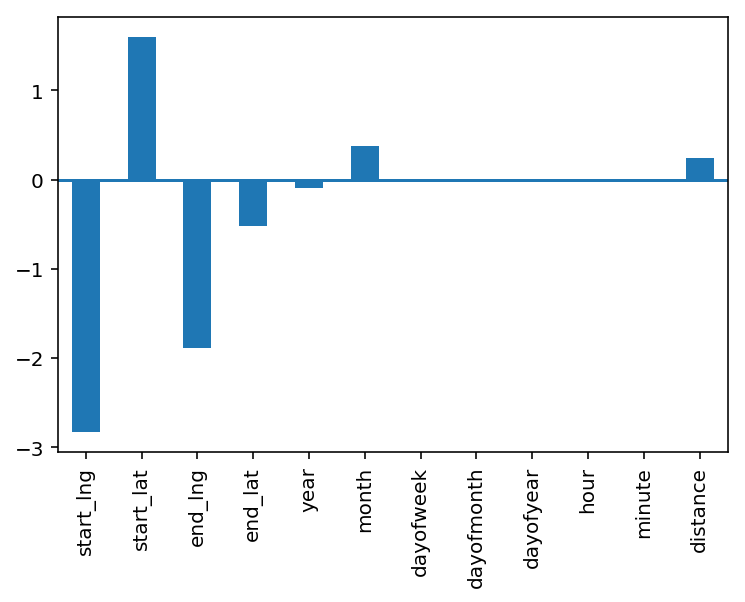

In [161]:
coef_df = pd.DataFrame()
coef_df["Covariate"] = X_train.columns.tolist()
coef_df["Coefficient"] = regr.coef_
coef_df

ax = coef_df["Coefficient"].plot.bar()
ax.set_xticklabels(coef_df["Covariate"])
plt.axhline(0)


In [167]:
# Gradient Boosted Regression model

gbr = ensemble.GradientBoostingRegressor()
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_validation)
gbr_MAE = mean_absolute_error(y_validation, gbr_pred)

print("Mean absolute error: ", gbr_MAE)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Mean absolute error:  0.305502575523


[Text(0,0,'start_lng'),
 Text(0,0,'start_lat'),
 Text(0,0,'end_lng'),
 Text(0,0,'end_lat'),
 Text(0,0,'year'),
 Text(0,0,'month'),
 Text(0,0,'dayofweek'),
 Text(0,0,'dayofmonth'),
 Text(0,0,'dayofyear'),
 Text(0,0,'hour'),
 Text(0,0,'minute'),
 Text(0,0,'distance')]

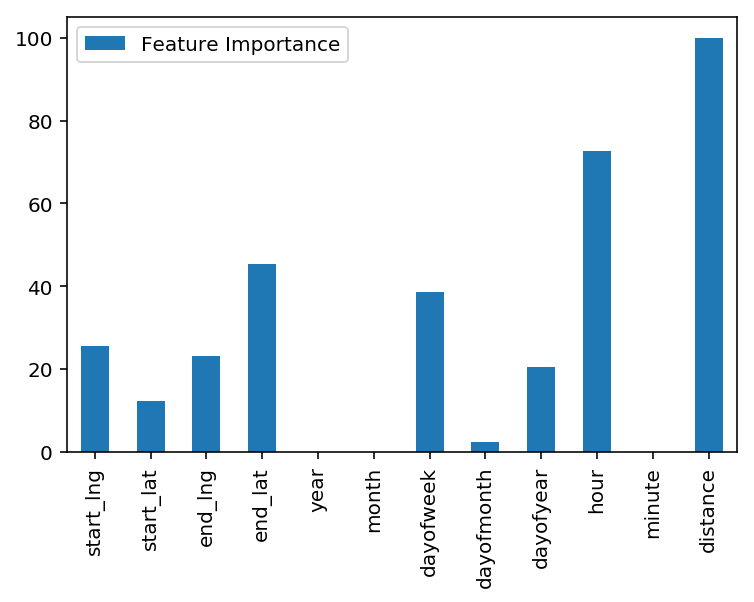

In [172]:
gbr_fi = pd.DataFrame()
gbr_fi["Feature Importance"] = 100*gbr.feature_importances_/max(gbr.feature_importances_)
gbr_fi["Covariate"] = X_train.columns.tolist()

ax = gbr_fi.plot.bar()
ax.set_xticklabels(gbr_fi["Covariate"])


In [ ]:
# Random Forest Regressor
